<a href="https://colab.research.google.com/github/yesyell/DA_School_1/blob/main/%EB%A8%B8%EC%8B%A0%EB%9F%AC%EB%8B%9D/%ED%95%B4%EC%84%9D%EB%AA%A8%ED%98%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# library import
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [ ]:
# 현재경로 확인
os.getcwd()

# 데이터 불러오기
data = pd.read_csv("./kc_house_data.csv")
data.head() # 데이터 확인

,id,date,price,bedrooms,bathrooms,floors,waterfront,condition,grade,yr_built,yr_renovated,zipcode,lat,long
0,7129300520,20141013T000000,221900.0,3,1.00,1.0,0,3,7,1955,0,98178,47.5112,-122.257
1,6414100192,20141209T000000,538000.0,3,2.25,2.0,0,3,7,1951,1991,98125,47.7210,-122.319
2,5631500400,20150225T000000,180000.0,2,1.00,1.0,0,3,6,1933,0,98028,47.7379,-122.233
3,2487200875,20141209T000000,604000.0,4,3.00,1.0,0,5,7,1965,0,98136,47.5208,-122.393
4,1954400510,20150218T000000,510000.0,3,2.00,1.0,0,3,8,1987,0,98074,47.6168,-122.045


In [ ]:
# shape 파악
nCar = data.shape[0] # 데이터 개수
nVar = data.shape[1] # 변수 개수
print('nCar: %d' % nCar, 'nVar: %d' % nVar )

nCar: 21613 nVar: 14


In [ ]:
# 의미가 없다고 생각되는 변수 제거
data = data.drop(['id', 'date', 'zipcode', 'lat', 'long'], axis = 1)

In [ ]:
feature_columns = list(data.columns.difference(['price'])) # price-target, 그 외 feature

X = data[feature_columns]
y = data['price']

train_x, test_x, train_y, test_y = train_test_split(
    X, y, test_size = 0.3, random_state = 42)

# train/test 비율을 7:3
print(train_x.shape, test_x.shape, train_y.shape, test_y.shape) # 데이터 확인

(15129, 8) (6484, 8) (15129,) (6484,)


In [ ]:
# lightgbm을 구현하여 shap value를 예측할 것

# library
import lightgbm as lgb  # 없을 경우 cmd/anaconda prompt에서 install
from math import sqrt
from sklearn.metrics import mean_squared_error

# lightgbm model
lgb_dtrain = lgb.Dataset(data = train_x, label = train_y) # LightGBM 모델에 맞게 변환
lgb_param = {'max_depth': 10,
            'learning_rate': 0.01, # Step Size
            'n_estimators': 1000, # Number of trees
            'objective': 'regression'} # 목적 함수 (L2 Loss)

lgb_model = lgb.train(params = lgb_param, train_set = lgb_dtrain) # 학습 진행
lgb_model_predict = lgb_model.predict(test_x) # test data 예측

print("RMSE: {}".format(sqrt(mean_squared_error(lgb_model_predict, test_y))))
# RMSE: 212217.42594653403

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 547.9/547.9 kB 12.4 MB/s eta 0:00:00


In [ ]:
# shap value를 이용하여 각 변수의 영향도 파악

# !pip install shap (에러 발생시, skimage version 확인 (0.14.2 이상 권장))
# import skimage -> skimage.__version__ (skimage version 확인)
# skimage version upgrade -> !pip install --upgrade scikit-image

# shap value
import shap
explainer = shap.TreeExplainer(lgb_model) # Tree model Shap Value 확인 객체 지정
shap_values = explainer.shap_values(test_x) # Shap Values 계산

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


 위의 과정은 첫 번째 test data instance에 대해 Shap Value를 적용하여 시각화한 것이다.

 빨간색이 양의 영향도가 높은 것이고, 파란색이 음의 영향도가 높은 것이다.

 즉 집의 condition과 bedrooms/bathrooms가 집 가격에 큰 양의 영향력을 주고,

 yr_bulit, floors, waterfront는 음의 영향력을 준다고 보여진다.

In [ ]:
shap.initjs() # javascript 초기화 (graph 초기화)
shap.force_plot(explainer.expected_value, shap_values[1,:], test_x.iloc[1,:])

 이는 전체 test데이터 셋에 대해서 적용한 것이다.

 가로축에는 변수와 sample order를 선택할 수 있는 피벗이 생성되고,

 세로축에는 각각의 변수에 대한 영향력과 model output value를 선택할 수 있는 피벗이 생성된다.

 이를 바꿔가면서 변수에 대한 영향력과 전반적인 모델의 설명을 확인할 수 있다.

In [ ]:
# 전체 검증 데이터 셋에 대해서 적용
shap.force_plot(explainer.expected_value, shap_values, test_x)

shap.plots.force is slow for many thousands of rows, try subsampling your data.


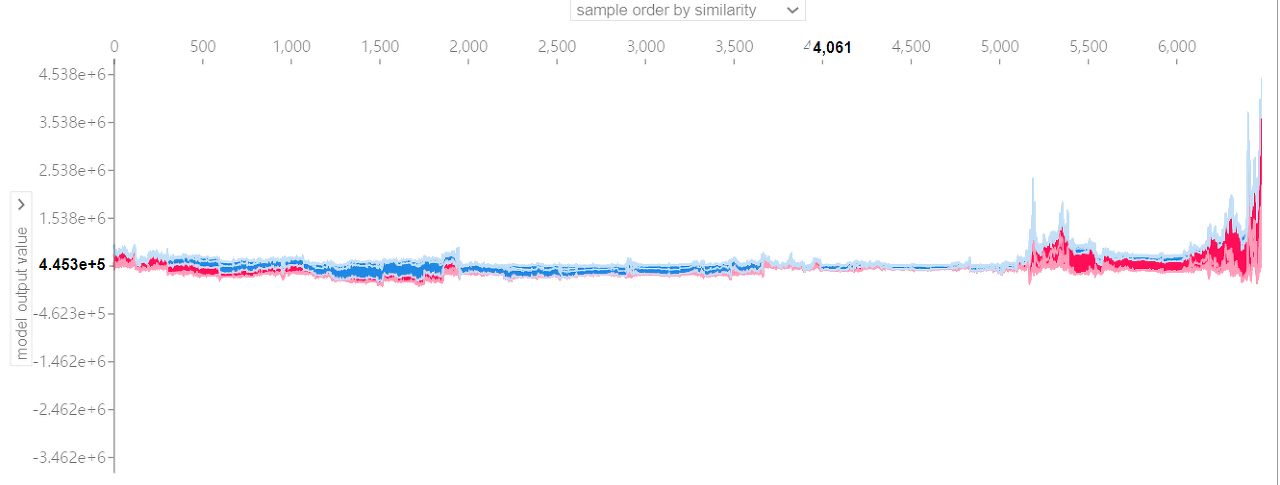

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


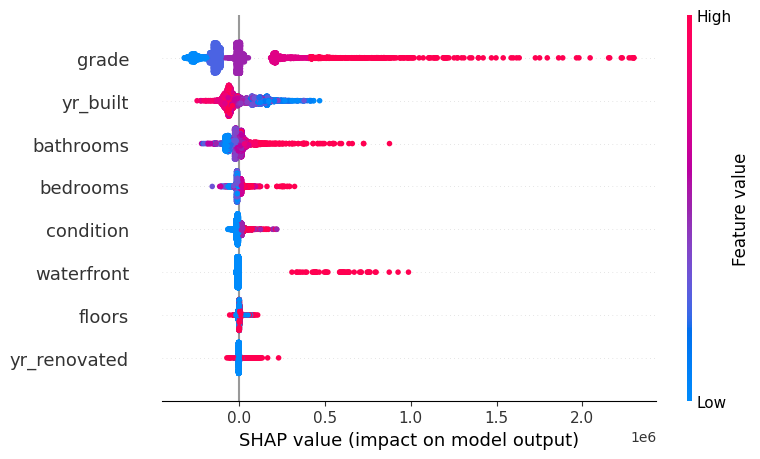

In [ ]:
# summary
shap.summary_plot(shap_values, test_x)

 위는 모든 변수들의 shap value를 요약한 것이다. 해당 변수가 빨간색을 띄면 target(price)에 대해 양의 영향력이 존재하는 것이고, 파란색을 띄면 음의 영향력이 존재하는 것이다. 해석을 하면 아래와 같다.

- grade : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
- yr_built : 변수의 값이 낮을 수록, 예상 가격이 높은 경향성이 있다.
- bathrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
- bedrooms : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
- condition : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다
- waterfront : 변수의 값이 높을 수록, 예상 가격이 높은 경향성이 있다.
- floors : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)
- yr_renovated : 해석 모호성 (Feature Value에 따른 Shap Values의 상관성 파악 모호)

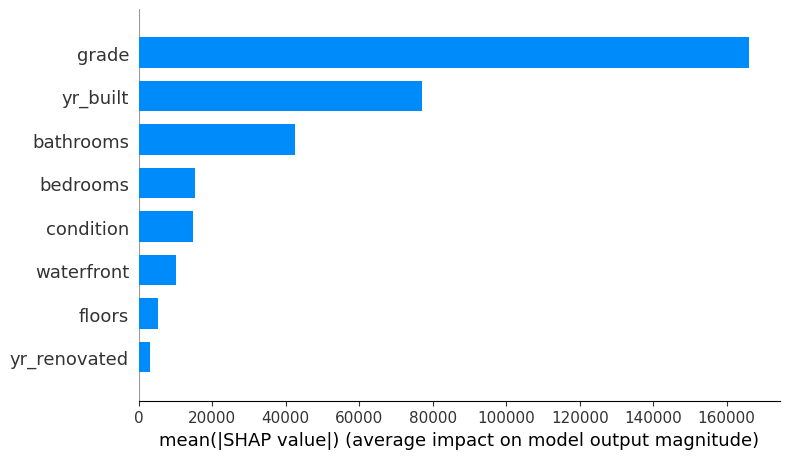

In [ ]:
 # 각 변수에 대한 |Shap Values|을 통해 변수 importance 파악
shap.summary_plot(shap_values, test_x, plot_type = "bar")

 이는 각 변수의 shap value에 절대값을 취한 것으로 변수의 평균적인 영향력을 보여준다.

 큰 영향력을 보일 수록, target과 관계성(인과관계X)이 크다는 것이다. 즉, 변수의 중요도와 비슷한 개념이다.

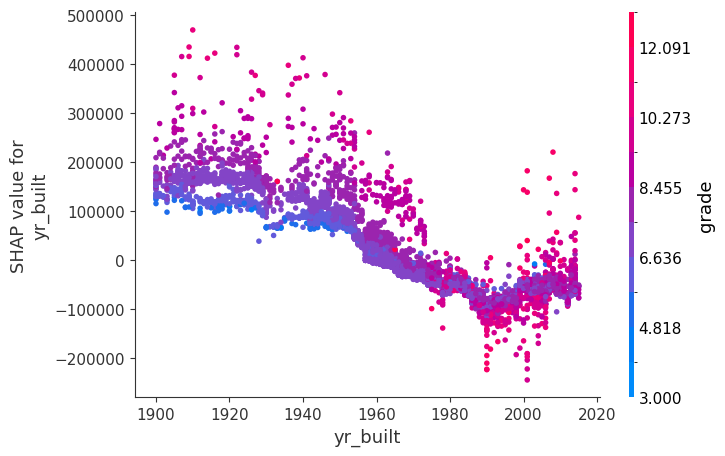

In [ ]:
 # 변수 간의 shap value 파악
shap.dependence_plot("yr_built", shap_values, test_x)

 이는 변수간 의존성을 보여주는 shap value이다.

 위를 보면, 빨간 점이 최신일수록 파란점에 비해 많이 분포하기에,
 최신 집일수록 grade가 높은 경향이 있다고 보여진다.

 shap value는 변수별로 산출을 할수도 있지만 그렇게 사용하기 보다는


 shap value의 실제값과 묶어서 shap value의 수치가 높을때 진짜 실제값과 상관성이 있는지를 파악해야한다.